This notebook explores clustering on subreddit text data as scraped and processed earlier.  Clustering is performed on the datasets generated both by producing document embeddings using [gensim](https://radimrehurek.com/gensim/) and sparse matrices as returned by sklearn's [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) vectorizer.  The general outline is as follows:  

(1) Read in text data  
(2) Produce clustering using K-Means  
(3) Find ideal k for K-Means  
(4) Utilize additional clustering algorithms: agglomerative clustering, DBSCAN, OPTICS, Affinity Propagation, and Spectral Clustering  
(5) Application: producing recommendations  
(6) Exploration of models using tf-idf vectorization

The documentation for the clustering algorithms can be found [here](https://scikit-learn.org/stable/modules/clustering.html).

In [1]:
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn import metrics


%matplotlib inline

## Clustering Subreddits

We start by reading in subreddit data.  Reading subs are excluded since they have insufficient data.

**Read in subs:**

In [2]:
cats = ['art', 'gaming', 'music', 'politics_news', 'science', 'sports', 'tech']
stem = 'lemma'

In [3]:
base = os.getcwd()
base = base.replace('\\', r'/')

In [4]:
documents = []

for cat in cats:
    os.chdir(fr'{base}/../Data/{cat}/Processed/{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'{base}/../Data/{cat}/Processed/{stem}/{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [5]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

**Using Gensim**

Next, we import our pre-trained document embeddings:

In [6]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [7]:
os.chdir(fr'{base}/../Data')

model = Doc2Vec.load('subs.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)
labels = np.array(documents[:, 2], dtype=int)

We'll start by training a K-Means model on our data.  Start by searching for optimal parameters.  Our metrics our sillhouette score, homogeneity, completeness, and v-score:

In [8]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, len(doc_scaled)))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

Let's graph our measures and corresponding k values:

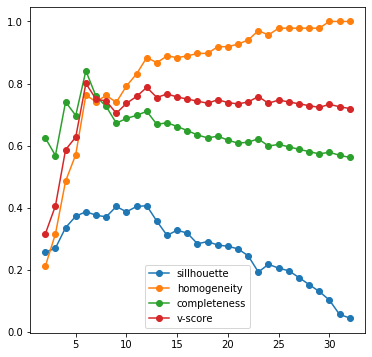

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Let's make an initial model using k equal to the number of categories provided:

Silhouette score: 0.3934578597545624
Homogeneity: 0.749
Completeness: 0.771
V-measure: 0.760
Inertia: 21.329829790726308



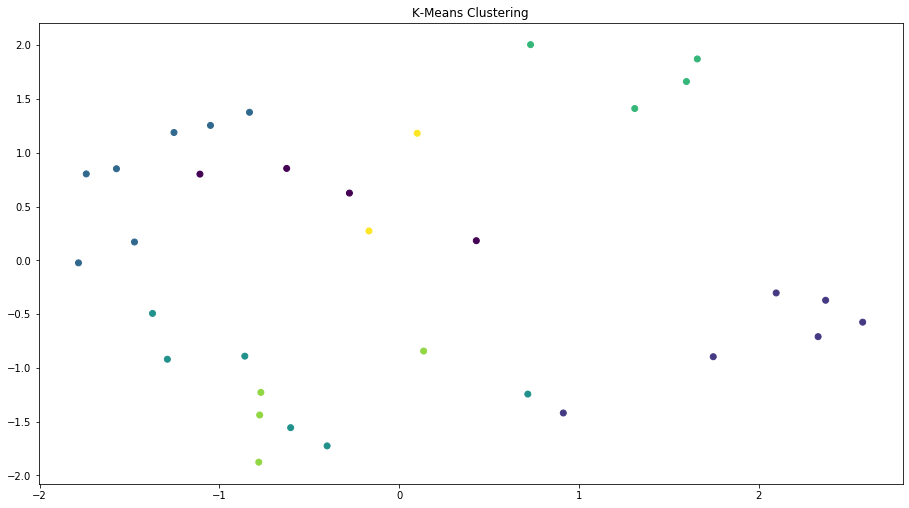

In [10]:
km = KMeans(n_clusters=len(cats))
km.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print(f'Inertia: {km.inertia_}\n')

These measures are decent, but the plotted metrics show that we can do better.  Let's choose k=12:

Silhouette score: 0.377789705991745
Homogeneity: 0.889
Completeness: 0.709
V-measure: 0.789
Inertia: 9.470139706973871



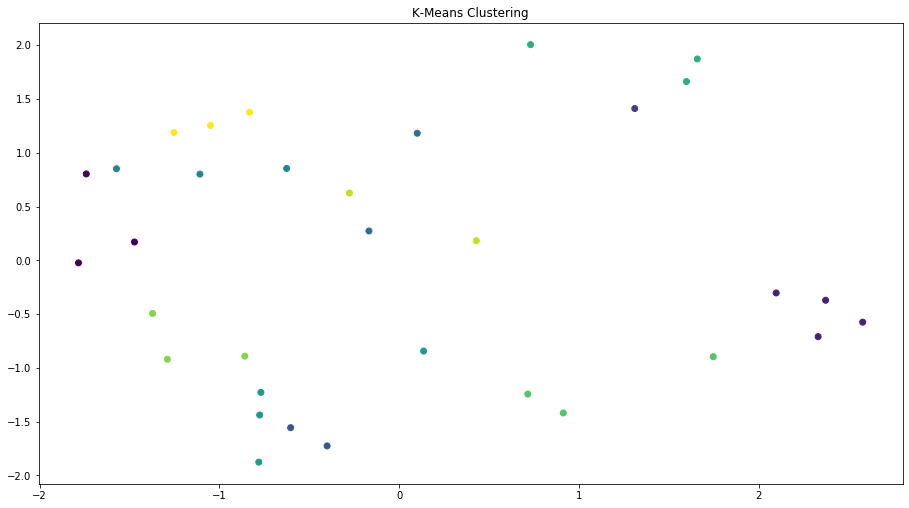

In [11]:
km = KMeans(n_clusters=12)
km.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print(f'Inertia: {km.inertia_}\n')

This is a decent clustering!  High homogeneity suggests that clusters contain subreddits that share a topic (e.g. sports subreddits tend to be in clusters together).  Low completeness suggests that, for example, not every sports subreddit is in the same cluster.  This is actually ok; think about sports subreddits: there are soccer, football, basketball, collegiate, and professional sports subreddits all grouped into the same loose category.  It makes sense that an ideal clustering might not group all of these subs together.  The sillhouette score almost can't be helped: our text data is not comprehensive enough to bring out the differences between each subreddit.

## Agglomerative Clustering

Now we can try other clustering methods.  Agglomerative clustering might be a good candidate:

In [12]:
from sklearn.cluster import AgglomerativeClustering

We'll do the same search for parameters as we did for K-Means:

In [13]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, len(doc_scaled)))
for k in list_k:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=agg.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, agg.labels_))
    com.append(metrics.completeness_score(labels, agg.labels_))
    v.append(metrics.v_measure_score(labels, agg.labels_))

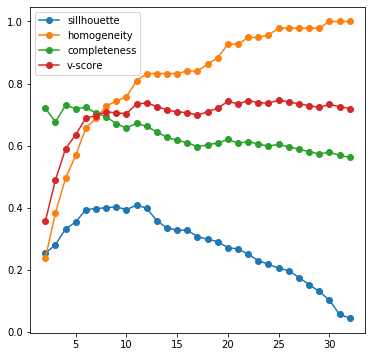

In [14]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Let's set n_clusters to 11 and see what kind of clustering is produced:

Silhouette score: 0.410948246717453
Homogeneity: 0.809
Completeness: 0.672
V-measure: 0.734


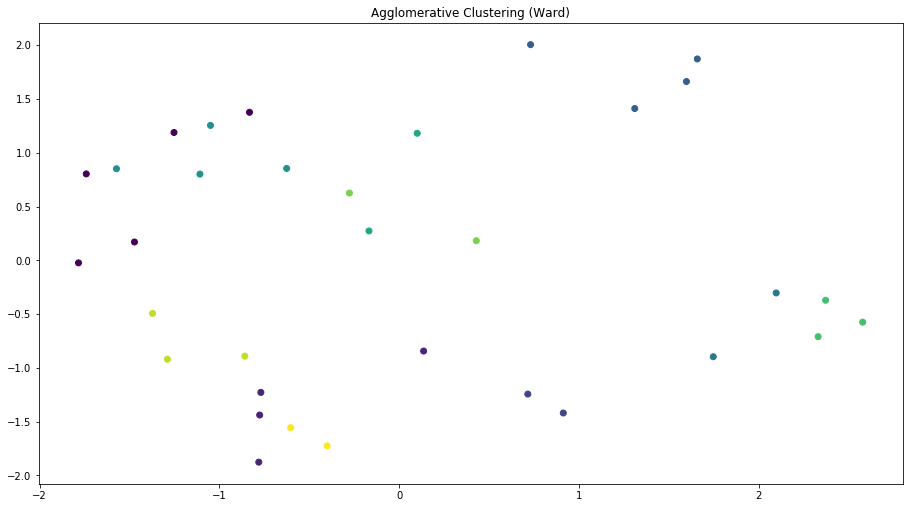

In [15]:
agg = AgglomerativeClustering(n_clusters=11, linkage='ward')
agg.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=agg.labels_)
    
ax.set_title('Agglomerative Clustering (Ward)')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=agg.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, agg.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, agg.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, agg.labels_))

This is a bit better than our K-Means clustering!

## DBSCAN

Let's try out even more clusterings.  For DBSCAN, we'll need to determine a value for epsilon:

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

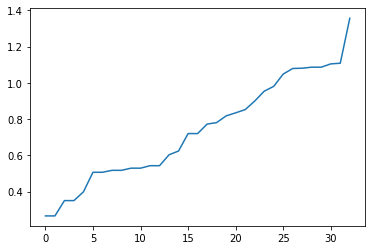

In [17]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(doc_scaled)
distances, indices = nn.kneighbors(doc_scaled)

distances = np.sort(distances, axis=0)[:, 1]

plt.plot(distances)

Setting eps to 0.6 makes a single cluster, but setting it higher can produce more.  Let's use eps=1.0:

Silhouette score: 0.08594968914985657
Homogeneity: 0.109
Completeness: 0.448
V-measure: 0.176


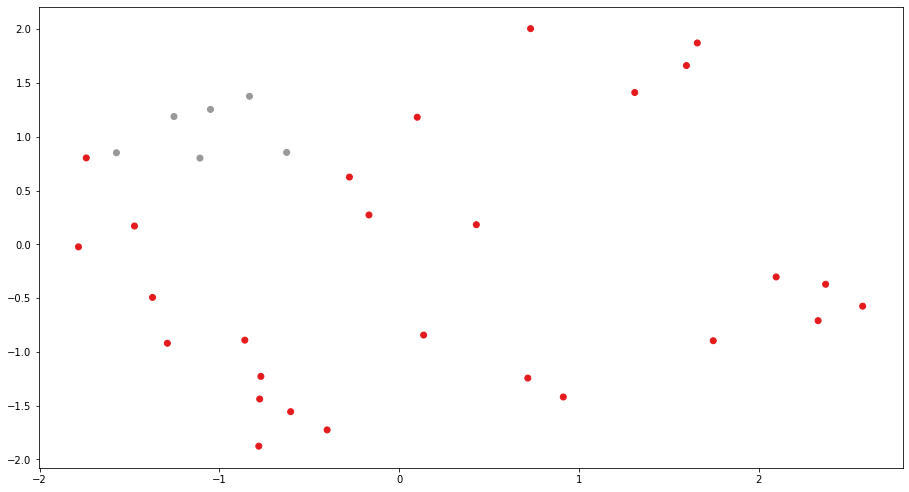

In [18]:
dbscan = DBSCAN(eps=1.0)
dbscan.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=dbscan.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=dbscan.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbscan.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbscan.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbscan.labels_))

This clustering produces only two clusters, which is a poor fit for our data and isn't of much use for making subreddit recommendations.  Let's move on to OPTICS, another density based algorithm:

In [19]:
from sklearn.cluster import OPTICS

Silhouette score: 0.17873616516590118
Homogeneity: 0.352
Completeness: 0.559
V-measure: 0.432


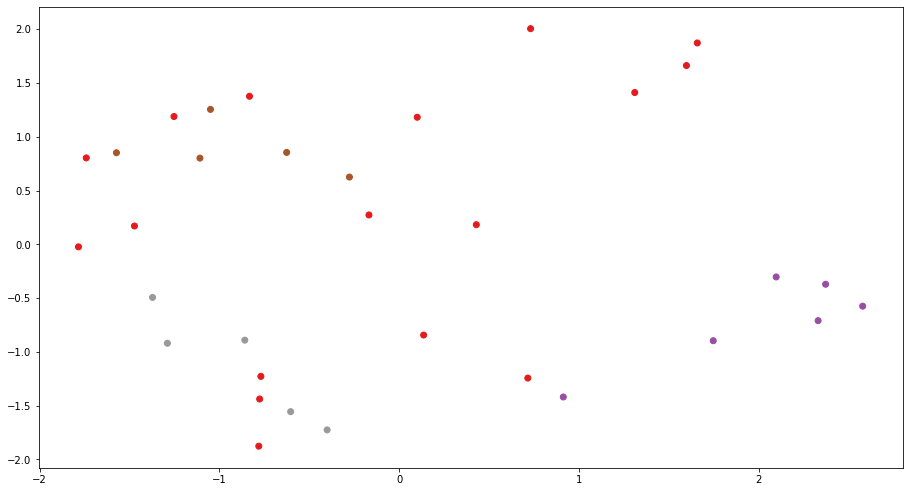

In [20]:
op = OPTICS()
op.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=op.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=op.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, op.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, op.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, op.labels_))

This is much better than a DBSCAN fit, but still not as good as either Agglomerative or K-Means.  Let's try some other algorithms, like Affinity Propagation and Spectral Clustering:

In [21]:
from sklearn.cluster import AffinityPropagation

Silhouette score: 0.3762623965740204
Homogeneity: 0.763
Completeness: 0.841
V-measure: 0.800


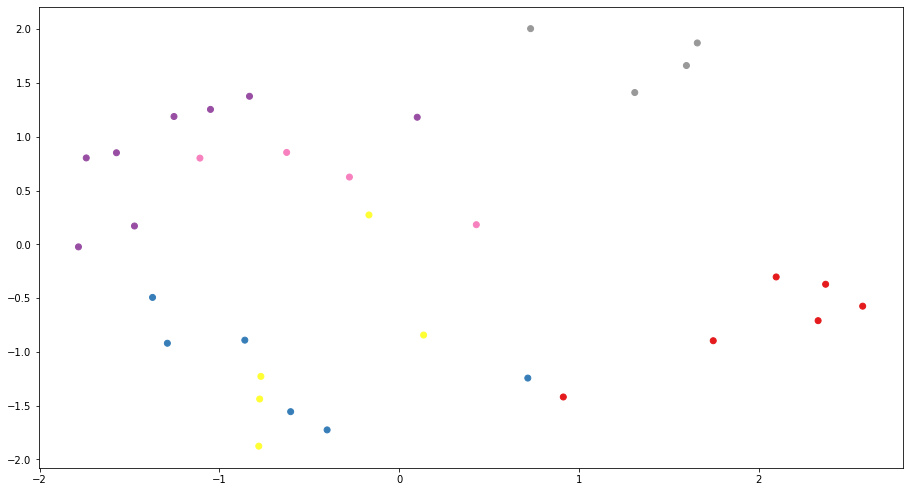

In [22]:
af = AffinityPropagation()
af.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=af.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=af.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))

In [23]:
from sklearn.cluster import SpectralClustering

In [24]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, len(doc_scaled)))
for k in list_k:
    sc = SpectralClustering(n_clusters=k)
    sc.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=sc.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, sc.labels_))
    com.append(metrics.completeness_score(labels, sc.labels_))
    v.append(metrics.v_measure_score(labels, sc.labels_))

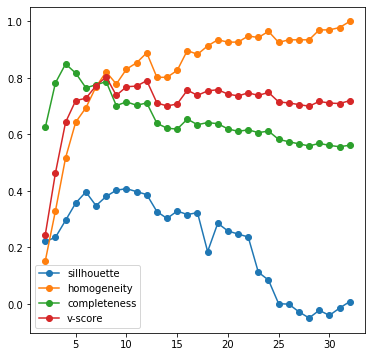

In [25]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Silhouette score: 0.4088957905769348
Homogeneity: 0.854
Completeness: 0.703
V-measure: 0.771


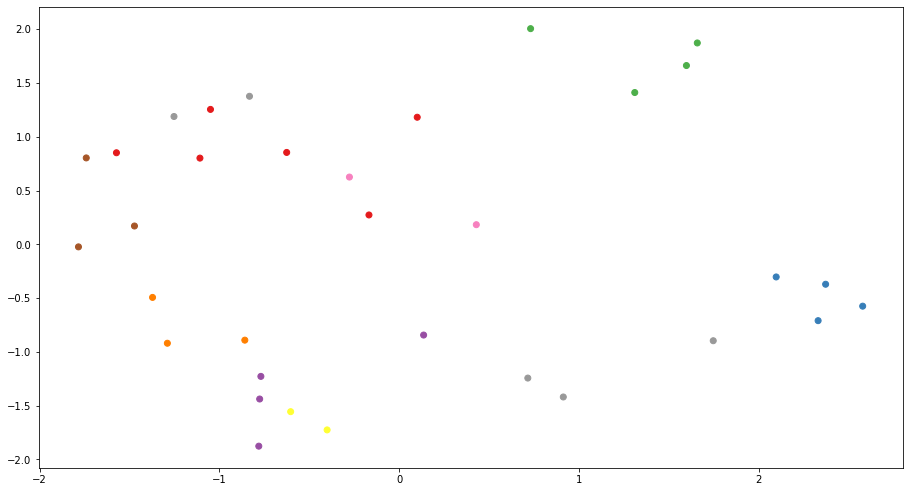

In [26]:
sc = SpectralClustering(n_clusters=11)
sc.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=sc.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=sc.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, sc.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, sc.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, sc.labels_))

Both Affinity Propagation and Spectral Clustering produce great clusterings!

## Application

We'll now consider a brief application of clustering.  We'll grab a random subreddit and first look at which subs are "closest" to it according to our gensim model.  Then, we'll make a cluster prediction and see which subs are clustered with the original by model.  These other subs in the cluster will be our recommendations:

In [27]:
docs = list(documents[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [28]:
doc_id = random.randint(0, len(tagged_data) - 1)
inferred_vector = model.infer_vector(tagged_data[doc_id][0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

indexes = np.array(sims[1:11], dtype=int)[:, 0]

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: PoliticalHumor
Sample category: politics_news


Let's look at what are the "closest" subreddits to r/PoliticalHumor, solely according to distance between embeddings:

In [29]:
for index in indexes:
    print(documents[index][3])

politics
news
nba
biology
worldnews
physics
futurology
psychology
science
technology


Most of these make sense: r/politics and r/news are both politics_news subs.  R/nba and r/biology don't make a whole lot of sense but there might be some cross-posting going on.  Let's look at which subs our models grab:

In [30]:
cluster = km.predict([doc_scaled[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

politics


The K-Means model grabs r/politics, which makes a lot of sense!  
For agglomerative clustering:

In [31]:
cluster = agg.labels_[doc_id]
same_cluster_index = np.where(agg.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

politics


The agglomerative model also grabs r/politics.

For affinity propagation:

In [32]:
cluster = af.labels_[doc_id]
same_cluster_index = np.where(af.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

news
politics
worldnews


This is a bigger cluster that includes both all politics_news subs.  This is great!

For spectral clustering:

In [33]:
cluster = sc.labels_[doc_id]
same_cluster_index = np.where(sc.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

politics


Again, only r/politics is grabbed.

## Without Using Word Embeddings

Now let's take a look at clustering without using word embeddings.  We'll create a sparse matrix using sklearn's tf-idf preprocessing, and then we'll look at what predictions it makes:

In [34]:
documents = []

for cat in cats:
    os.chdir(fr'{base}/../Data/{cat}/Processed/{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'{base}/../Data/{cat}/Processed/{stem}/{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [35]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [36]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X_plot = tfidf_vectorizer.fit_transform(documents[:, 0])
svd_plot = TruncatedSVD(n_components=2)
X_plot = svd_plot.fit_transform(X_plot)

tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [37]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, len(X)))
for k in list_k:
    km = KMeans(n_clusters=len(cats))
    km.fit(X)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

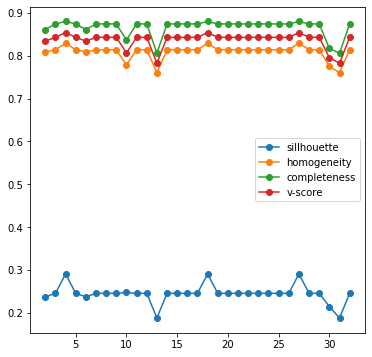

In [38]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Here, it actually looks like there's a relative maxima for all measures at k=10!  Let's build a model:

Silhouette score: 0.5303484673927152
Homogeneity: 0.851
Completeness: 0.780
V-measure: 0.814


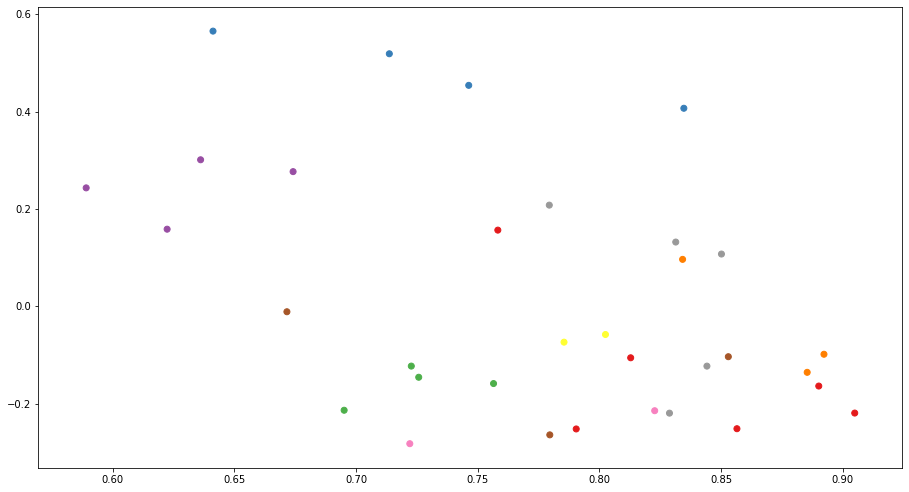

In [39]:
km = KMeans(n_clusters=10, init='k-means++')
km.fit(X)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=sc.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

It looks like our tf-idf K-Means model is actually a bit clearer than our document embedding K-Means model.  The problem with using tf-idf vectorization is that it is simply not scalable.  Dimensionality reduction is another parameter to be trained, and training on a sparse matrix with tens of thousands of columns would be a serious undertaking.  Nonetheless, we can use this model to make recommendations:

In [40]:
doc_id = random.randint(0, len(tagged_data) - 1)

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: xboxone
Sample category: gaming


In [41]:
cluster = km.predict([X[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

games
gaming
pcgaming
ps4


Let's try it with another sub:

In [42]:
doc_id = random.randint(0, len(tagged_data) - 1)

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: musicology
Sample category: music


In [43]:
cluster = km.predict([X[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

It looks like r/musicology gets clustered by itself.